# Basic examples
This notebook outlines the construction of Hamiltonians which are not inherently useful
on their own, but are of a similar form to what we expect for the most basic
simulations where a quantum computer may be useful. This version is a working version and
will likely be updated later to include more application relevant examples.  The dynamic
simulation of these Hamiltonians can be thought of as a necessary but not sufficient
condition for demonstrating the viability of a quantum computer as a useful tool for 
quanutm dynamic simulation.

Note that running this entire notebook should take on the order of an hour.
To see smaller cases, simply reduce the sizes of the lattices for the various Hamiltonians.

## Basic Hamiltonian
In this section we consider the time independent transverse field Ising Hamiltonians represented by graphs
with a lattice structure. There are more complicated models which would likely
be interesting to simulate, but as an initial pass we start by considering two models
* 32x32 Triangular Lattice (1024 spins, 2 dimensions) with antiferromagnetic unit couplings
* 12x12x12 Cubic Lattice (1728 spins, 3 dimensions) with random unit couplings
The transverse field Ising Hamiltonian for a lattice graph, $G = (V,E)$ is as follows:

\begin{equation}
H = \sum_{i \in V} \Gamma_{i}\sigma_{i}^{x} + \sum_{i \in V} h_{i} \sigma_{i}^{z} + \sum_{(i,j) \in E} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z}
\end{equation}
Note that in the instances presented here, we do not consider local longitudinal field terms ($\boldsymbol{h}=0$), though this may not always be the case.
We also do not consider in this example the state preparation circuit that may be required as that is heavily application dependent.
For the purposes of these initial experiments, we can assume that the initial state is an eigenstate of either the $X$ or $Z$ basis since the preparation circuits for these have $O(1)$ depth.

To be clear, the dynamic simulations mean simulating the Schrodinger Equation
\begin{equation}
i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle
\end{equation}
with solution
\begin{equation}
|\psi(t)\rangle = e^{-\frac{i}{\hbar}H t}|\psi(0)\rangle
\end{equation}

A subgraph of each lattice is plotted below to clarify the graph structure to clarify the graph structure.

In [1]:
import os
import random
import numpy as np
import networkx as nx
from networkx import grid_graph
from networkx.classes.graph import Graph
from qca.utils.utils import plot_histogram
from qca.utils.algo_utils import estimate_qsp, estimate_trotter
from networkx.generators.lattice import hexagonal_lattice_graph
from qca.utils.hamiltonian_utils import (nx_triangle_lattice, flatten_nx_graph,
                                         generate_square_hamiltonian, pyliqtr_hamiltonian_to_openfermion_qubit_operator,
                                         assign_directional_triangular_labels, generate_triangle_hamiltonian,
                                         assign_hexagon_labels)


/Users/jonhas/anaconda3/lib/python3.11/site-packages/attr/_make.py:918: RuntimeWarning: Running interpreter doesn't sufficiently support code object introspection.  Some features like bare super() or accessing __class__ will not work with slotted classes.
  set_closure_cell(cell, cls)


In [2]:
from pyLIQTR.utils.Hamiltonian import Hamiltonian as pyH

In [3]:
lattice_size = 3
graph_square = grid_graph(dim = (lattice_size, lattice_size))
graph_triangle = nx_triangle_lattice(lattice_size)
graph_cube = grid_graph(dim = (lattice_size, lattice_size, lattice_size))

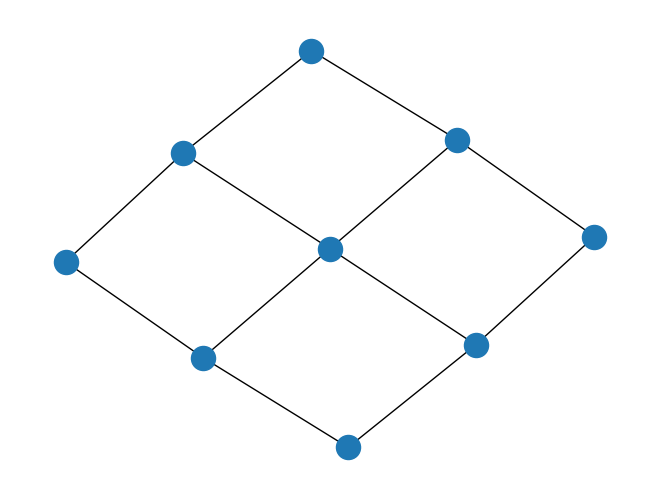

In [4]:
nx.draw(graph_square)

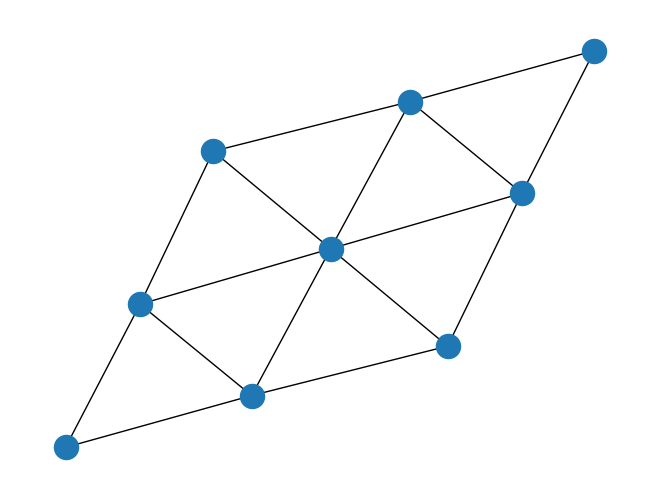

In [5]:
nx.draw(graph_triangle)

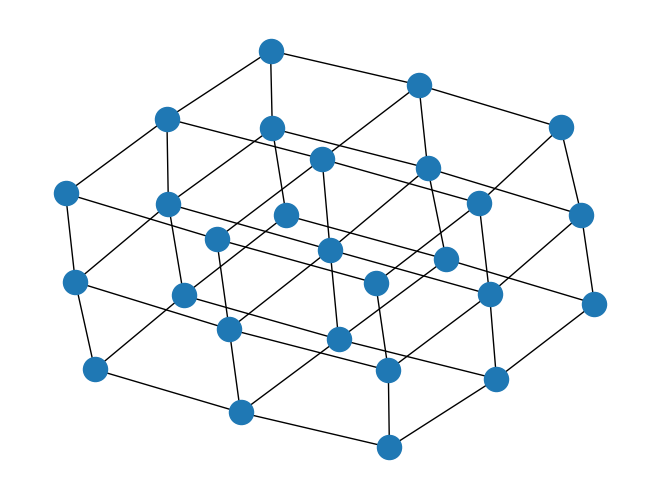

In [6]:
nx.draw(graph_cube)

Now that we have an idea of what our Hamiltonians look like, we can begin generating them in a form accepted by pyLIQTR.

In [7]:
## initializing seed for consistent results for the cubic lattice and generating Hamiltonians
random.seed(0)
np.random.seed(0)
square_lattice_size=10
triangle_lattice_size=32
cubic_lattice_size=12
test_lattice_size=3

square_hamiltonian = generate_square_hamiltonian(square_lattice_size, dim=2)
cubic_hamiltonian = generate_square_hamiltonian(cubic_lattice_size, dim=3)
triangular_hamiltonian = generate_triangle_hamiltonian(triangle_lattice_size)

Now that we have generated our Hamiltonians, we can start generating the circuits for a preferred dynamic simulation method (e.g., QSP, Trotter 4th order, ...).  Shown below is QSP.

In [8]:
timesteps=1000
required_precision = 1e-16

#feeding square Hamiltonian to PyLIQTR for circuit generation
H_square = pyH(square_hamiltonian[0] + square_hamiltonian[1])
H_triangle = pyH(triangular_hamiltonian[0] + triangular_hamiltonian[1])
H_cube = pyH(cubic_hamiltonian[0] + cubic_hamiltonian[1])

Now we need to extract resource estimates for each of the subcircuits of the high level circuit.  The information which we are interested in is as follows:
* Total gate count for full circuit
* Total depth for full circuit
* Decomposed QASM circuit for each subcircuit
* Clifford + T circuits for each subcircuit
* Total T gate count for each subcircuit
* Total Clifford count for each subcircuit
* T gate depth for each subcircuit

This information can be extracted by obtaining the information for each subcircuit and multiplying by the number of repetitions of the subcircuits.  In this
notebook, we show the process for both QSP and second order Suzuki-Trotter, though this process could likely be generalized to many quantum algorithms.
It should be noted that the approach shown here provides a slight over-estimation since it assumes that each of the subcircuits operate in serial.  This
assumption is valid for both QSP and second order Suzuki-Trotter since the operations which consume the bulk of the circuit volume do operate in serial
(Select and Reflect Operations and Trotter steps respectively).

In [9]:
print('Estimating Square', flush=True)
qsp_circ_square = estimate_qsp(H_square,
                               timesteps,
                               required_precision,
                               'QSP/square_circuits/',
                               hamiltonian_name='square_qsp',
                               timestep_of_interest=1)
print('Estimating Triangle', flush=True)
qsp_circ_triangle = estimate_qsp(H_triangle,
                                 timesteps,
                                 required_precision,
                                 'QSP/triangle_circuits/',
                                 hamiltonian_name='triangle_qsp',
                                 timestep_of_interest=1)
print('Estimating Cube', flush=True)
qsp_circ_cube = estimate_qsp(H_cube,
                             timesteps,
                             required_precision,
                             'QSP/cube_circuits/',
                             hamiltonian_name='cube_qsp',
                             timestep_of_interest=1)
print('Finished estimating', flush=True)

Estimating Square
Time to generate high level QSP circuit: 0.07817474997136742 seconds
   Time to decompose high level <class 'cirq.ops.pauli_gates._PauliX circuit: 0.00016433402197435498 seconds 
   Time to transform decomposed <class 'cirq.ops.pauli_gates._PauliX circuit to Clifford+T: 2.358300844207406e-05 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.Rx circuit: 5.2749994210898876e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.common_gates.Rx circuit to Clifford+T: 0.006720417004544288 seconds
   Time to decompose high level <class 'pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit: 0.012332000012975186 seconds 
   Time to transform decomposed <class 'pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit to Clifford+T: 0.9447329170070589 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.Ry circuit: 0.0001978750224225223 seconds 
   Time to transform decomposed <class 'cirq.ops

# More complicated Hamiltonian
There are a few ways to make the simulation task more challenging and more application relevant.
The Kitaev honeycomb model is hypothesized to be a good model for the structure of many materials (see for example [here](https://www.sciencedirect.com/science/article/pii/S0370157321004051)).  This model is appealing for quantum simulation purposes because while the behavior in the infinite time regime is [understood](https://www.cambridge.org/core/books/introduction-to-topological-quantum-computation/kitaevs-honeycomb-lattice-model/85E968DD7C54F8062C4EAF5394DAAAF6), the behavior with minor perturbations to the model or the dynamics of the model are not so well [understood](https://courses.physics.illinois.edu/phys598PTD/fa2013/L26.pdf).  The Kitaev honeycomb model consists of directionally defined $XX$, $YY$, and $ZZ$ couplings on a honeycomb lattice.  These assignments are denoted in the plot below by 'X', 'Y', or 'Z' respectively.

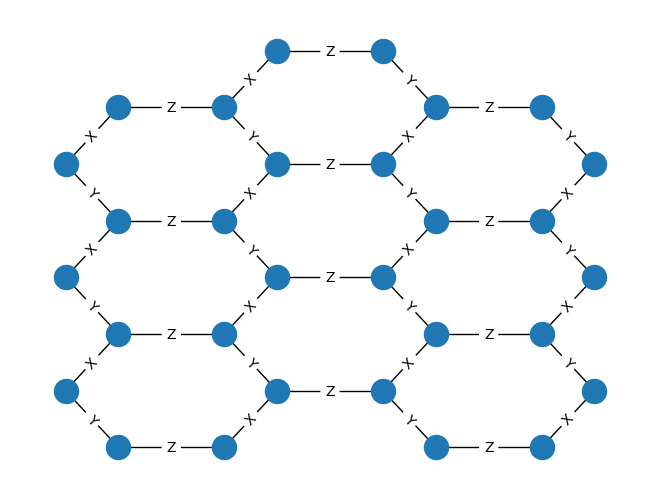

In [10]:
hexagon_graph = hexagonal_lattice_graph(3,3)
pos = nx.get_node_attributes(hexagon_graph, 'pos')
assign_hexagon_labels(hexagon_graph, 'X', 'Y', 'Z')
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in hexagon_graph.edges(data=True)]);
nx.draw(hexagon_graph, pos)
nx.draw_networkx_edge_labels(hexagon_graph, pos,edge_labels = edge_labels);

From this graph we can generate the Hamiltonian
\begin{equation*}
H_{\text{Kitaev}} = \sum_{(i,j) \in X \text{ edges}} J_{i,j} \sigma_i^x \sigma_j^x + \sum_{(i,j) \in Y \text{ edges}} J_{i,j} \sigma_i^y \sigma_j^y + \sum_{(i,j) \in Z \text{ edges}} J_{i,j} \sigma_i^z \sigma_j^z
\end{equation*}

In [11]:
def nx_kitaev_terms(g:Graph, p:float) -> list:
    hamiltonian = []
    n = len(g.nodes)
    for (n1, n2, d) in g.edges(data=True):
        label = d['label']
        weight = 1 if random.random() < p else -1
        pauli_string = n * 'I'
        for i in range(len(g)):
            if i == n1 or i == n2:
                pauli_string = f'{pauli_string[:i]}{label}{pauli_string[i+1:]}'
            else:
                pass
        hamiltonian.append((pauli_string, weight))
    return hamiltonian

def generate_kitaev_hamiltonian(lattice_size:int, weight_prob:float=1):
    graph = hexagonal_lattice_graph(lattice_size,lattice_size)
    assign_hexagon_labels(graph, 'X', 'Y', 'Z')
    graph = flatten_nx_graph(graph)
    H = nx_kitaev_terms(graph, weight_prob)
    return H


In [12]:
# lattice_size_kitaev = 3
lattice_size_kitaev = 32
kitaev_hamiltonian = generate_kitaev_hamiltonian(lattice_size_kitaev)

timesteps = 1000
required_precision = 1e-16
H_kitaev = pyH(kitaev_hamiltonian)
print('Estimating Kitaev', flush=True)
qsp_circ_kitaev = estimate_qsp(H_kitaev, timesteps, 
                               required_precision, 
                               'QSP/kitaev_circuits/',
                               hamiltonian_name='kitaev_qsp',
                               timestep_of_interest=1)
print('Finished Estimating', flush=True)

Estimating Kitaev
Time to generate high level QSP circuit: 9.264041874965187 seconds
   Time to decompose high level <class 'cirq.ops.pauli_gates._PauliX circuit: 8.708401583135128e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.pauli_gates._PauliX circuit to Clifford+T: 1.837499439716339e-05 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.Rx circuit: 4.32920060120523e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.common_gates.Rx circuit to Clifford+T: 0.007617708994075656 seconds
   Time to decompose high level <class 'pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit: 0.12723804195411503 seconds 
   Time to transform decomposed <class 'pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit to Clifford+T: 12.060515165969264 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.Ry circuit: 0.001234666968230158 seconds 
   Time to transform decomposed <class 'cirq.ops.common

In [13]:
def generate_directional_triangular_hamiltonian(lattice_size:int, weight_prob:float = 1):
    graph = nx_triangle_lattice(lattice_size)
    assign_directional_triangular_labels(graph,lattice_size)
    graph = flatten_nx_graph(graph)
    H = nx_kitaev_terms(graph, weight_prob)
    return H

g_triangle = nx_triangle_lattice(3)
assign_directional_triangular_labels(g_triangle,3)

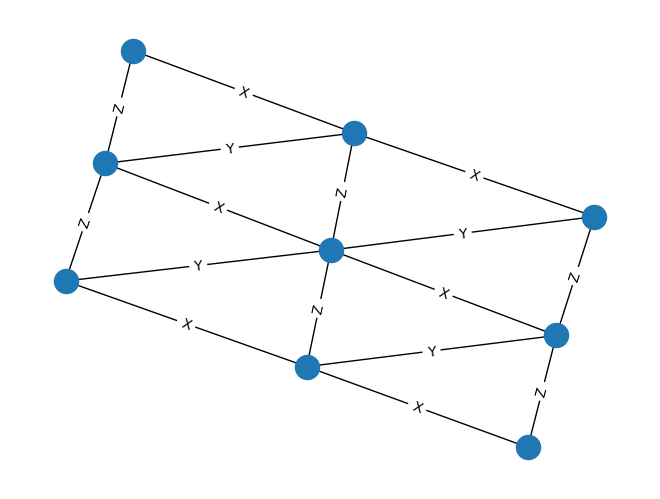

In [14]:
graph_triangle = nx_triangle_lattice(3)
assign_directional_triangular_labels(graph_triangle, 3)
pos = nx.spring_layout(graph_triangle)
edge_labels = dict([((n1, n2), d['label']) for n1, n2, d in graph_triangle.edges(data=True)]);
nx.draw(graph_triangle, pos)
nx.draw_networkx_edge_labels(graph_triangle, pos,edge_labels = edge_labels);

In [15]:
lattice_size_directional_triangle = 32
# lattice_size_directional_triangle = 3
directional_triangle_hamiltonian = generate_directional_triangular_hamiltonian(lattice_size_directional_triangle)

timesteps = 1000
required_precision = 1e-16
timestep_of_interest = 1 # sim_time
H_directional_triangle = pyH(directional_triangle_hamiltonian)

print('Estimating Directional Triangle', flush=True)
qsp_circ_directional_triangle = estimate_qsp(H_directional_triangle, timesteps,
                                             required_precision, 'QSP/directional_triangle_circuits/',
                                             hamiltonian_name='directional_triangle_qsp',
                                             timestep_of_interest=1)
print('Finished Estimating', flush=True)

Estimating Directional Triangle
Time to generate high level QSP circuit: 4.334049750003032 seconds
   Time to decompose high level <class 'cirq.ops.pauli_gates._PauliX circuit: 9.066599886864424e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.pauli_gates._PauliX circuit to Clifford+T: 1.8833030480891466e-05 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.Rx circuit: 5.6958990171551704e-05 seconds 
   Time to transform decomposed <class 'cirq.ops.common_gates.Rx circuit to Clifford+T: 0.007146999996621162 seconds
   Time to decompose high level <class 'pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit: 1.1349652910139412 seconds 
   Time to transform decomposed <class 'pyLIQTR.circuits.operators.hamiltonian_encodings.UnitaryBlockEncode circuit to Clifford+T: 14.06300804199418 seconds
   Time to decompose high level <class 'cirq.ops.common_gates.Ry circuit: 0.0013668750179931521 seconds 
   Time to transform decomposed <class 

# Trotter imeplementations
Now we can do all of this again for second order Suzuki Trotter rather than QSP.  Below we will see how to construct a single trotter step of second order Suzuki-Trotter for these hamiltonians along with a loose upper bound for the number of trotter steps required.  According to the [documentation](https://quantumai.google/reference/python/openfermion/circuits/error_bound) from openfermion the trotter step estimate for the second order Suzuki-Trotter expansion.

In [16]:
# Translating the hamiltonians from above into a form usable by openfermion
openfermion_hamiltonian_square = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_square)
openfermion_hamiltonian_triangle = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_triangle)
openfermion_hamiltonian_cube = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_cube)
openfermion_hamiltonian_kitaev = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_kitaev)
openfermion_hamiltonian_directional_triangle = pyliqtr_hamiltonian_to_openfermion_qubit_operator(H_directional_triangle)

## Estimates
Trotterizing the Hamiltonians and writing estimates to files

In [17]:
# defining precision required for the trotterized circuit
energy_precision = 1e-6
timesteps=1000

In [18]:
print('Estimating Square', flush=True)
cpt_trotter_square = estimate_trotter(openfermion_hamiltonian_square,
                                      timesteps, energy_precision,
                                      'Trotter/square_circuits/',
                                      hamiltonian_name='square_trotter',
                                      write_circuits=True)
print('Estimating Triangle', flush=True)
cpt_trotter_triangle = estimate_trotter(openfermion_hamiltonian_triangle,
                                        timesteps, energy_precision,
                                        'Trotter/triangle_circuits/',
                                        hamiltonian_name='triangle_trotter',
                                        write_circuits=True)
print('Estimating Cube', flush=True)
cpt_trotter_cube = estimate_trotter(openfermion_hamiltonian_cube,
                                    timesteps, energy_precision,
                                    'Trotter/cube_circuits/',
                                    hamiltonian_name='cube_trotter',
                                    write_circuits=True)
print('Estimating Kitaev', flush=True)
cpt_trotter_kitaev = estimate_trotter(openfermion_hamiltonian_kitaev,
                                      timesteps, energy_precision,
                                      'Trotter/kitaev_circuits/',
                                      hamiltonian_name='kitaev_trotter',
                                      write_circuits=True)
print('Estimating Directional Triangle', flush=True)
cpt_trotter_directional_triangle = estimate_trotter(openfermion_hamiltonian_directional_triangle, 
                                                    timesteps, energy_precision, 'Trotter/directional_triangle_circuits/', 
                                                    hamiltonian_name='directional_triangle_trotter',
                                                    write_circuits=True)
print('Finished with estimates', flush=True)

Estimating Square
Time to estimate number of trotter steps required (5366564): 0.01873741700546816 seconds
Time to find term ordering: 0.0011674999841488898 seconds
Time to generate trotter circuit from openfermion: 4.792003892362118e-06 seconds
Time to generate a clifford + T circuit from trotter circuit: 2.170036625000648 seconds
Estimating Triangle
Time to estimate number of trotter steps required (21707142): 2.4065036670072004 seconds
Time to find term ordering: 0.022789958980865777 seconds
Time to generate trotter circuit from openfermion: 4.041008651256561e-06 seconds
Time to generate a clifford + T circuit from trotter circuit: 44.901897875010036 seconds
Estimating Cube
Time to estimate number of trotter steps required (27573901): 6.595473208988551 seconds
Time to find term ordering: 0.04128233401570469 seconds
Time to generate trotter circuit from openfermion: 1.2909877113997936e-06 seconds
Time to generate a clifford + T circuit from trotter circuit: 67.47965512500377 seconds


In [19]:
figdir = 'Trotter/Figures/'
widthdir = 'Trotter/Widths/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(widthdir):
    os.makedirs(widthdir)

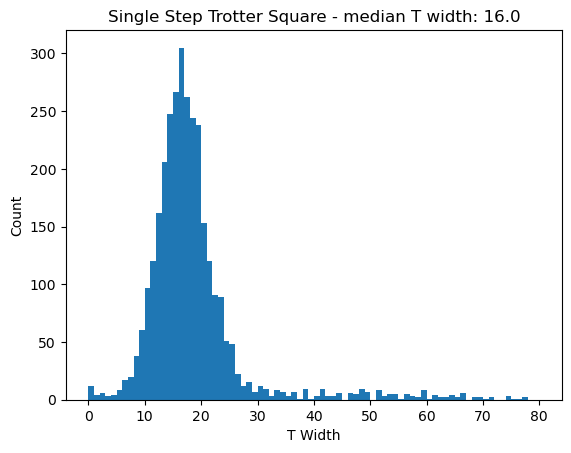

In [20]:
plot_histogram(
    cpt_trotter_square,
    'Single Step Trotter Square',
    figdir,
    widthdir
)

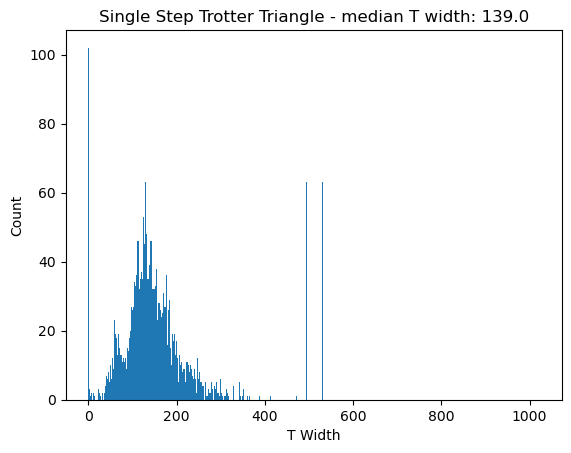

In [21]:
plot_histogram(
    cpt_trotter_triangle,
    'Single Step Trotter Triangle',
    figdir,
    widthdir
)

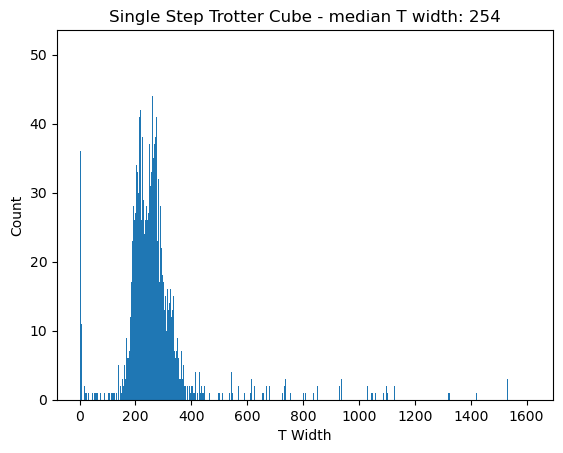

In [22]:
plot_histogram(
    cpt_trotter_cube,
    'Single Step Trotter Cube',
    figdir,
    widthdir
)

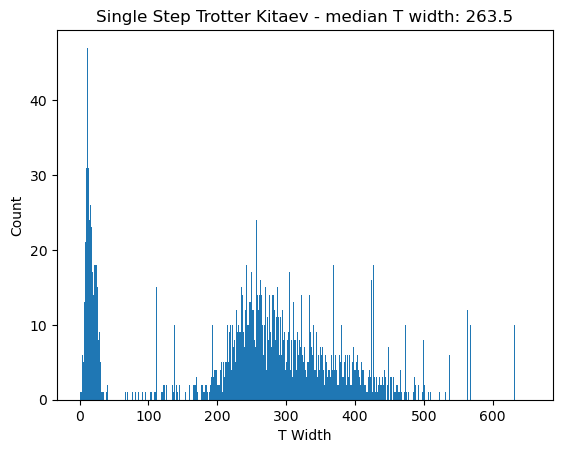

In [23]:
plot_histogram(
    cpt_trotter_kitaev,
    'Single Step Trotter Kitaev',
    figdir,
    widthdir
)

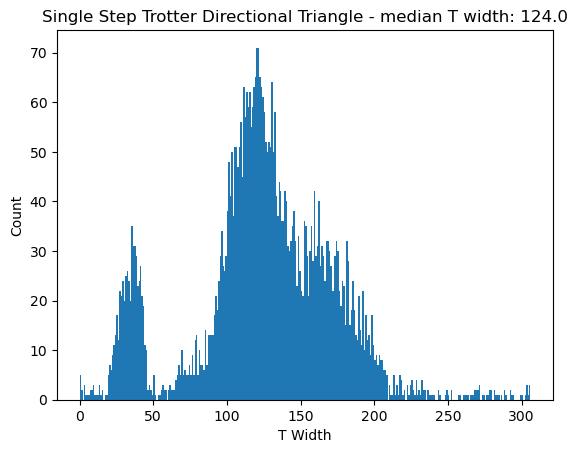

In [24]:
plot_histogram(
    cpt_trotter_directional_triangle,
    'Single Step Trotter Directional Triangle',
    figdir,
    widthdir
)